<a href="https://colab.research.google.com/github/Hamada-Gado/IEEE-GUC-Deep-Learning-Tasks/blob/main/IEEE_Session_2_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we're going to use Pytorch to train a logistic regression model. 

This notebook won't be exploring the real power of deep neural networks we won't have any hidden layers so it's not "deep" and it can't represent nonlinear relationships in the data.

The code, however, is very much similar to what deep neural network code looks like, that is, most of the code you use here you will be useful when writing code for a deep neural network. 

This notebook just helps get you familiar with the main steps of defining and training a neural network in Pytorch.

We will compare it with the last week's model which was implemented using classical machine learning libraries (scikit-learn).

We'll start by importing PyTorch and its related packages 

In [1]:
import math

import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import log_loss, accuracy_score, classification_report

# set default device based on CUDA's availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# A very quick intro to PyTorch

**what are tensors?**
* tensors are multi-dimensional arrays with support for autograd operations
* autograd is a mechanism for computing gradients of tensor operations
* tensors are similar to numpy's ndarrays, but with additional features
* tensors can be moved to GPU for faster computation
* tensors can be used to represent data and parameters in a model

In [2]:
x = torch.tensor(22.0, requires_grad=True, dtype=torch.float32, device=device)
print(f"tensor x: {x}, x.grad: {x.grad}")
y = x ** 2
print(f"tensor y: {y}, y.grad_fn: {y.grad_fn}")
dy_dx = 2 * x
y.backward() # equivalent to torch.autograd.grad(y, x), but with the gradient stored in x.grad, instead of being returned
print(f"dy_dx: {dy_dx}, x.grad: {x.grad}")

tensor x: 22.0, x.grad: None
tensor y: 484.0, y.grad_fn: <PowBackward0 object at 0x74bcc7d6dfc0>
dy_dx: 44.0, x.grad: 44.0


In [3]:
# x.numpy() This will raise an error if x is not on the CPU
# either
x = x.to('cpu')
# or
x = x.cpu()

# if tensor requires grad, then we will need to detach it from the computation graph, otherwise, it will raise an error
x.detach().numpy()

array(22., dtype=float32)

In [4]:
# Some operations are not differentiable, and we can use torch.no_grad() to avoid tracking gradients
with torch.no_grad():
    y = x ** 2
    # y.backward()  this will raise an error
    print(f"y: {y}, y.grad_fn: {y.grad_fn}")

y: 484.0, y.grad_fn: None


In [5]:
# some features of the tensor which are similar to numpy
x = torch.randn(2, 3)
print(f"x: {x}, x.shape: {x.shape}, x.size(): {x.size()}")
print(f"x.mean(): {x.mean():.2f}, x.std(): {x.std():.2f}, x.sum(): {x.sum():.2f}")
print(f"x.view(1, -1): {x.view(1, -1)}")

x: tensor([[-1.7807, -1.1101,  1.5913],
        [ 0.9705,  1.0729,  0.1550]]), x.shape: torch.Size([2, 3]), x.size(): torch.Size([2, 3])
x.mean(): 0.15, x.std(): 1.34, x.sum(): 0.90
x.view(1, -1): tensor([[-1.7807, -1.1101,  1.5913,  0.9705,  1.0729,  0.1550]])


We will now load the data, but skip looking at it and the preprocessing in depth as we did in the pervious week.

In [6]:
cat_columns: list[str] = ["Gender", "Embarked"]
num_columns: list[str] = ["Pclass", "Age", "SibSp", "Parch"]

# Create a pipeline for the categorical columns using OneHotEncoder
cat_pipeline: Pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))


# Create a pipeline for the numerical columns using MinMaxScaler
num_pipeline: Pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    MinMaxScaler())

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_columns),
    ("cat", cat_pipeline, cat_columns),
])

In [7]:
train_data = pd.read_csv("./train.csv")
train_data = train_data.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis= 1)
X = train_data.drop('Survived', axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, train_data['Survived'], test_size=0.2, random_state=42)

X_train = preprocessing.fit_transform(X_train)
X_test = preprocessing.transform(X_test)

now we will transform the data into a tensor, and then we will split it into training and testing sets.

In [8]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)

Next we'll define a very simple class to load the data, it loads the data, then defines the `__len__` method to get its size and the `__getitem__` method to get a single example and its ground truth

In [9]:
class LogisticDataset(Dataset):
    def __init__(self, X, y):
        assert X.size()[0] == y.size()[0]
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.size()[0]
    
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]


We'll use PyTorch's `DataLoader` class to generate the dataloader for our training data. We give it as input an instance of our dataset and specify the `batch_size` and set `shuffle=True` so that it provides batches in random order. 

In [10]:
batch_size = 4
train_dataloader = DataLoader(LogisticDataset(X_train, y_train), batch_size=batch_size, shuffle=True)


We can now loop through the dataloader to get batches of data at each iteration. 

In [11]:
for i, (data, label) in enumerate(train_dataloader):
    print(data)
    print(label)
    break


tensor([[1.0000, 0.4471, 0.1250, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [1.0000, 0.2209, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [1.0000, 0.3466, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.4220, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000]],
       device='cuda:0')
tensor([1., 0., 0., 0.], device='cuda:0')


Do note that each time we loop through the data, it will have different order. That's because we've set shuffle=True. This helps the model become more robust as it gets batches in a different order in each epoch (pass through the training data so it reduces overfitting.

In [12]:
for i, (data, label) in enumerate(train_dataloader):
    print(data)
    print(label)
    break


tensor([[0.5000, 0.6482, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [1.0000, 0.0324, 0.3750, 0.1667, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.4974, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [1.0000, 0.2963, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000]],
       device='cuda:0')
tensor([0., 0., 1., 0.], device='cuda:0')


If we count how many iterations we go through in train_dataloader we find that it does 178 iterations. That's because we have a total of 712 examples and a `batch_size` of 4. Changing the batch size should affect the number of iterations, which are generally `number of examples / batch_size`

In [13]:
counter = 0
for i, (data, label) in enumerate(train_dataloader):
    pass
print(i + 1)


178


**Defining the Logistic Regression model using Pytorch**

In [14]:
X_train.shape

torch.Size([712, 9])

In [35]:
class LogisticRegression(nn.Module):
    def __init__(self, num_inputs=9, num_outputs=1, **kwargs):
        super(LogisticRegression, self).__init__(**kwargs)
        # The layer should have an input of shape 9 and an output of shape 1

        # If we use only this layer, the model will be exactly like a logistic regression
        # self.fc1 = nn.Linear(num_inputs, num_outputs, bias=True)

        # This will be the code of a more complex model
        self.fc1 = nn.Linear(num_inputs, 256, bias=True)
        self.fc2 = nn.Linear(256, 128, bias=True)
        self.fc3 = nn.Linear(128, num_outputs, bias=True)
        ###############################################

    def forward(self, x):
        x = self.fc1(x)

        # This will be the code of a more complex model
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        ###############################################

        x = torch.sigmoid(x)
        x = x.squeeze(1) # remove the last dimension: [batch_size, 1] -> [batch_size], [[0.4]] --> [0.4]
        return x


net = LogisticRegression()
net.to(device)

LogisticRegression(
  (fc1): Linear(in_features=9, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)

**Use Binary Categorical Cross-Entropy loss**

In [36]:
loss_fn = nn.BCELoss(reduction='mean')

**Use Stochastic Gradient Descent for optimizing the model**

In [37]:
optimizer = optim.Adam(net.parameters(), lr= 1e-3)

**Complete the training loop and train the model**

In [38]:
num_examples = len(train_dataloader.dataset)
epochs = 200
num_batches = math.ceil(num_examples / batch_size)
losses = []

for epoch in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_dataloader):
        data = data.to(device)
        label = label.to(device)

        yhat = net(data) # net.forward(data) don't do this
        loss = loss_fn(yhat, label) # Call the loss function you defined earlier
        
        # Call the zero_grad method of the optimizer you defined
        optimizer.zero_grad()

        # Call the backward method of the loss tensor you just calculated
        loss.backward()

        # Call the step method of the optimizer 
        optimizer.step()

        cumulative_loss += loss.item()
    print("Epoch %s, loss: %s" % (epoch, cumulative_loss / num_examples))
    losses.append(cumulative_loss / num_batches)


Epoch 0, loss: 0.13017127681732849
Epoch 1, loss: 0.11486714435845949
Epoch 2, loss: 0.11197503570341662
Epoch 3, loss: 0.110393357672467
Epoch 4, loss: 0.1088966964482424
Epoch 5, loss: 0.10975265530136864
Epoch 6, loss: 0.10862990454613661
Epoch 7, loss: 0.10952905827107724
Epoch 8, loss: 0.1063844664388577
Epoch 9, loss: 0.10635417237291846
Epoch 10, loss: 0.10551824672880132
Epoch 11, loss: 0.10516209633539567
Epoch 12, loss: 0.10581274521066232
Epoch 13, loss: 0.10372491801429666
Epoch 14, loss: 0.10474698305695077
Epoch 15, loss: 0.10165870251929325
Epoch 16, loss: 0.10208180813338566
Epoch 17, loss: 0.10316091828738873
Epoch 18, loss: 0.10149165233492516
Epoch 19, loss: 0.10258416252817666
Epoch 20, loss: 0.10128981711635932
Epoch 21, loss: 0.10075569244394644
Epoch 22, loss: 0.10015969256232127
Epoch 23, loss: 0.09976011243115147
Epoch 24, loss: 0.09685606764775984
Epoch 25, loss: 0.09945889660209585
Epoch 26, loss: 0.0987001725268456
Epoch 27, loss: 0.09963262872770429
Epoch 2

Now we can plot the average loss of the model for each epoch it trained.

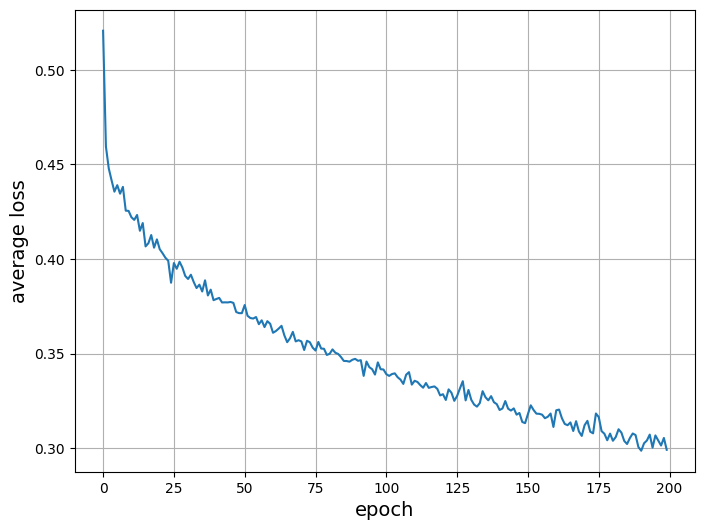

In [40]:
plt.figure(num=None, figsize=(8, 6))
plt.plot(losses)

plt.grid(True, which="both")
plt.xlabel('epoch', fontsize=14)
plt.ylabel('average loss', fontsize=14)
plt.show()


In [41]:
predictions = (
    net(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().detach().numpy()
)
predictions = (predictions > 0.5).astype(int)

log_loss_ = log_loss(y_test, predictions)
acc_score = accuracy_score(y_test, predictions)

print(f"Log loss: {log_loss_}")
print(f"Accuracy score: {acc_score}")
print(classification_report(y_test, predictions))

Log loss: 7.853086492600944
Accuracy score: 0.7821229050279329
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       105
           1       0.78      0.66      0.72        74

    accuracy                           0.78       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.78      0.78      0.78       179

